In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import simweights
import pickle
import os, sys
import numpy as np
import matplotlib as mat
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import pandas as pd
import tables
import h5py
import math
from scipy.stats import mstats
import matplotlib as mpl
import matplotlib.font_manager as font_manager



In [3]:
sys.path.append("/data/user/tvaneede/GlobalFit/run_taupede_ftp/notebooks")
from weights import *
from utils import *
from files import files
from selections import create_selections
from fonts import *


In [4]:
# version and plotting path
version = "taupede_v6"
files = files[version]


In [5]:
main_plotting_path = f"/data/user/tvaneede/GlobalFit/run_taupede_ftp/notebooks/output/{version}"
os.system(f"mkdir -p {main_plotting_path}")

0

In [6]:
# open the files
for flavor in files:
    files[flavor]['hdf_file'] = pd.HDFStore(files[flavor]['file_path'],'r')
    files[flavor]['variables'] = get_variables( files[flavor]['hdf_file'] )
    files[flavor] = Append_Weights( files[flavor] )


In [7]:
keys_to_merge = {
    # "NuE" : ["NuE_E2", "NuE_E3"],
    # "NuMu" : ["NuMu_E2", "NuMu_E3"],
    # "NuTau" : ["NuTau_E2", "NuTau_E3"],
    # "NuAll" : ['NuE', "NuMu", "NuTau"],
    "NuAll" : ["NuTau_E2", "NuTau_E3"],

}

for new_key in keys_to_merge:
    files[new_key] = {}
    files[new_key]['variables'] = {}

    for key in keys_to_merge[new_key]:
        for variable in files[key]['variables']:
            if variable not in files[new_key]['variables']:
                files[new_key]['variables'][variable] = []
            files[new_key]['variables'][variable].append( pd.Series(files[key]['variables'][variable]) )
    
    for variable in files[new_key]['variables']:
        files[new_key]['variables'][variable] = pd.concat(files[new_key]['variables'][variable])


In [8]:
from selections import create_selections

In [9]:
selections = create_selections( files["NuAll"] )

In [10]:
from plot_utils import *

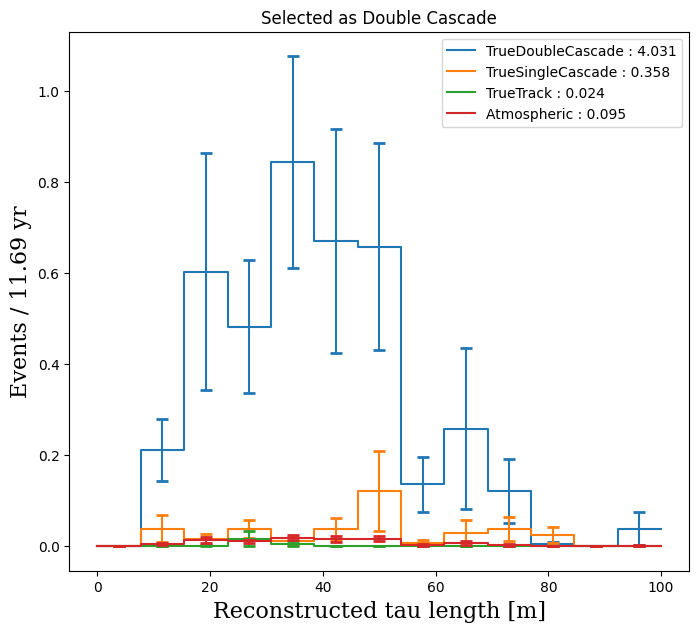

In [11]:
bins = np.linspace(0,100,14)
livetime_yr = 11.687
livetime_s  = livetime_yr * 365.25 * 24 * 3600 # 11.687 year

for variable in ["RecoL"]:

    plotting_path = f"{main_plotting_path}/{variable}"
    os.system(f"mkdir -p {plotting_path}")

    fig, ax = plt.subplots(1, 1,figsize =(8,7))

    for selection_name in ["DoubleCascade_TrueDoubleCascade", "DoubleCascade_TrueSingleCascade", "DoubleCascade_TrueTrack"]:
        
        selection = selections[selection_name]
        selection_name = selection_name.split("_")[1]

        y = np.abs(files['NuAll']['variables'][variable][ selection ])
        w = files['NuAll']['variables']['Weights_Astro'][selection]

        hist,hist_err = make_hist_error(samples=y, bins=bins,weights=w*368813893.34)

        label = f"{selection_name} : {sum(hist):.3f}"

        plot_hist_errorbar(ax=ax,hist=hist,bins=bins,yerror=hist_err,label=label)
    
    # atmospheric neutrinos
    selection_name = "DoubleCascade"
    selection = selections[selection_name]
    y = np.abs(files['NuAll']['variables'][variable][ selection ])
    w = files['NuAll']['variables']['Weights_Atmospheric'][selection]
    hist,hist_err = make_hist_error(samples=y, bins=bins,weights=w*368813893.34)
    label = f"Atmospheric : {sum(hist):.3f}"
    plot_hist_errorbar(ax=ax,hist=hist,bins=bins,yerror=hist_err,label=label)

    ax.legend()
    ax.set_ylabel(f"Events / {livetime_yr:.2f} yr",fontdict=font_axis_label)
    ax.set_xlabel("Reconstructed tau length [m]",fontdict=font_axis_label)
    ax.set_title("Selected as Double Cascade")
    plt.savefig(f"{plotting_path}/{variable}_selection-NehaHESE.pdf")


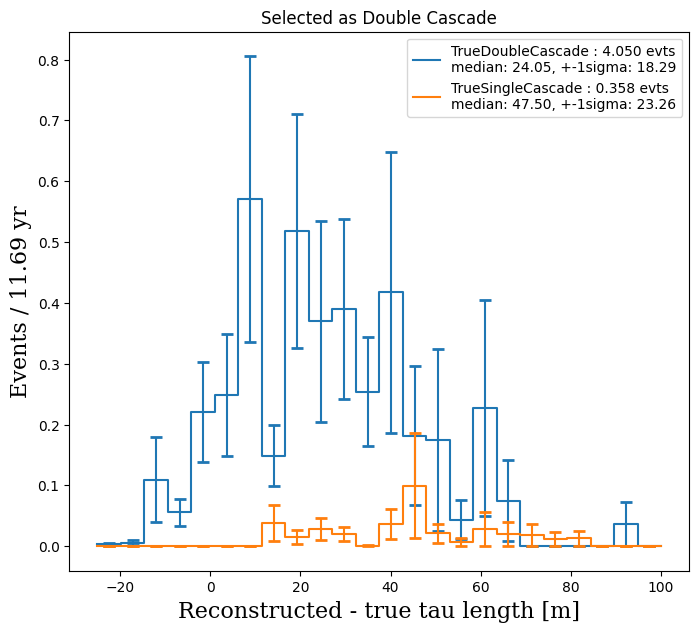

In [17]:
# length resolution
bins = np.linspace(-25,100,25)
livetime_yr = 11.687
livetime_s  = livetime_yr * 365.25 * 24 * 3600 # 11.687 year

for variable in ["RecoL"]:

    plotting_path = f"{main_plotting_path}/{variable}_resolution"
    os.system(f"mkdir -p {plotting_path}")

    fig, ax = plt.subplots(1, 1,figsize =(8,7))

    for selection_name in ["DoubleCascade_TrueDoubleCascade", "DoubleCascade_TrueSingleCascade"]:
        
        selection = selections[selection_name]
        selection_name = selection_name.split("_")[1]

        y = np.abs(files['NuAll']['variables'][variable][ selection ]) - files['NuAll']['variables']['TrueL'][ selection ]
        w = files['NuAll']['variables']['Weights_Astro'][selection]

        hist,hist_err = make_hist_error(samples=y, bins=bins,weights=w*368813893.34)

        quantiles = weighted_quantile( values=y, quantiles=[0.16,0.5,0.84], sample_weight=w)

        label = f"{selection_name} : {sum(hist):.3f} evts\nmedian: {quantiles[1]:.2f}, +-1sigma: {(quantiles[2]-quantiles[0])/2:.2f}"

        plot_hist_errorbar(ax=ax,hist=hist,bins=bins,yerror=hist_err,label=label)

    ax.legend()
    ax.set_ylabel(f"Events / {livetime_yr:.2f} yr",fontdict=font_axis_label)
    ax.set_xlabel("Reconstructed - true tau length [m]",fontdict=font_axis_label)
    ax.set_title("Selected as Double Cascade")
    plt.savefig(f"{plotting_path}/{variable}_resolution_selection-NehaHESE.pdf")


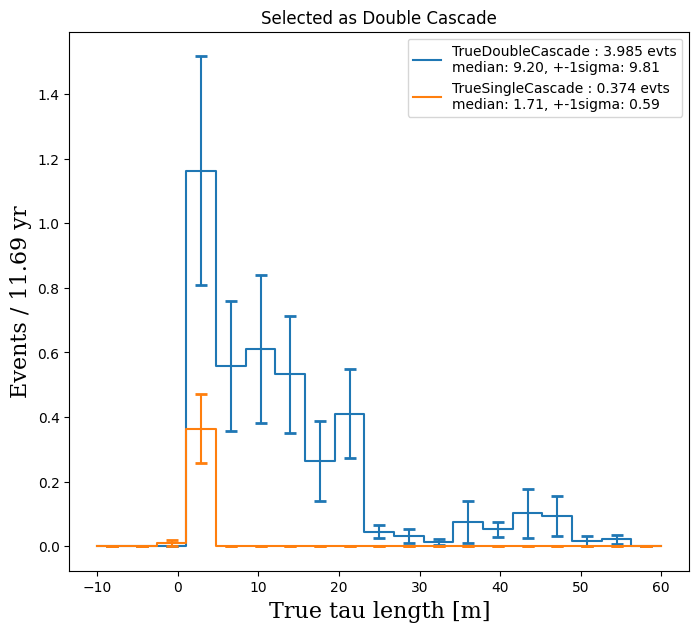

In [14]:
# true length
bins = np.linspace(-10,60,20)
livetime_yr = 11.687
livetime_s  = livetime_yr * 365.25 * 24 * 3600 # 11.687 year
variable = "TrueL"

plotting_path = f"{main_plotting_path}/{variable}"
os.system(f"mkdir -p {plotting_path}")


fig, ax = plt.subplots(1, 1,figsize =(8,7))

for selection_name in ["DoubleCascade_TrueDoubleCascade", "DoubleCascade_TrueSingleCascade"]:
    
    selection = selections[selection_name]
    selection_name = selection_name.split("_")[1]

    y = np.abs(files['NuAll']['variables'][variable][ selection ])
    w = files['NuAll']['variables']['Weights_Astro'][selection]

    hist,hist_err = make_hist_error(samples=y, bins=bins,weights=w*368813893.34)

    quantiles = weighted_quantile( values=y, quantiles=[0.16,0.5,0.84], sample_weight=w)

    label = f"{selection_name} : {sum(hist):.3f} evts\nmedian: {quantiles[1]:.2f}, +-1sigma: {(quantiles[2]-quantiles[0])/2:.2f}"

    plot_hist_errorbar(ax=ax,hist=hist,bins=bins,yerror=hist_err,label=label)

ax.legend()
ax.set_ylabel(f"Events / {livetime_yr:.2f} yr",fontdict=font_axis_label)
ax.set_xlabel("True tau length [m]",fontdict=font_axis_label)
ax.set_title("Selected as Double Cascade")
plt.savefig(f"{plotting_path}/{variable}_selection-NehaHESE.pdf")

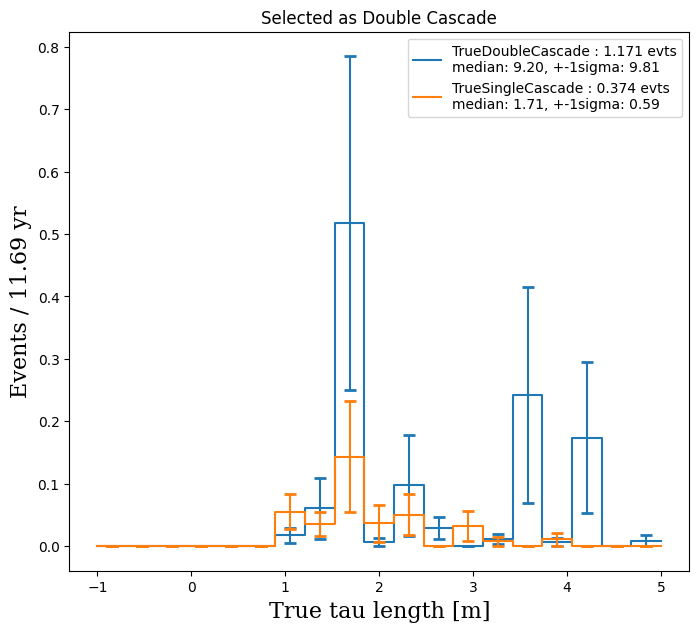

In [15]:
# true length
bins = np.linspace(-1,5,20)
livetime_yr = 11.687
livetime_s  = livetime_yr * 365.25 * 24 * 3600 # 11.687 year
variable = "TrueL"

plotting_path = f"{main_plotting_path}/{variable}"
os.system(f"mkdir -p {plotting_path}")

fig, ax = plt.subplots(1, 1,figsize =(8,7))

for selection_name in ["DoubleCascade_TrueDoubleCascade", "DoubleCascade_TrueSingleCascade"]:
    
    selection = selections[selection_name]
    selection_name = selection_name.split("_")[1]

    y = np.abs(files['NuAll']['variables'][variable][ selection ])
    w = files['NuAll']['variables']['Weights_Astro'][selection]

    hist,hist_err = make_hist_error(samples=y, bins=bins,weights=w*368813893.34)

    quantiles = weighted_quantile( values=y, quantiles=[0.16,0.5,0.84], sample_weight=w)

    label = f"{selection_name} : {sum(hist):.3f} evts\nmedian: {quantiles[1]:.2f}, +-1sigma: {(quantiles[2]-quantiles[0])/2:.2f}"

    plot_hist_errorbar(ax=ax,hist=hist,bins=bins,yerror=hist_err,label=label)

ax.legend()
ax.set_ylabel(f"Events / {livetime_yr:.2f} yr",fontdict=font_axis_label)
ax.set_xlabel("True tau length [m]",fontdict=font_axis_label)
ax.set_title("Selected as Double Cascade")
plt.savefig(f"{plotting_path}/{variable}_zoom_selection-NehaHESE.pdf")

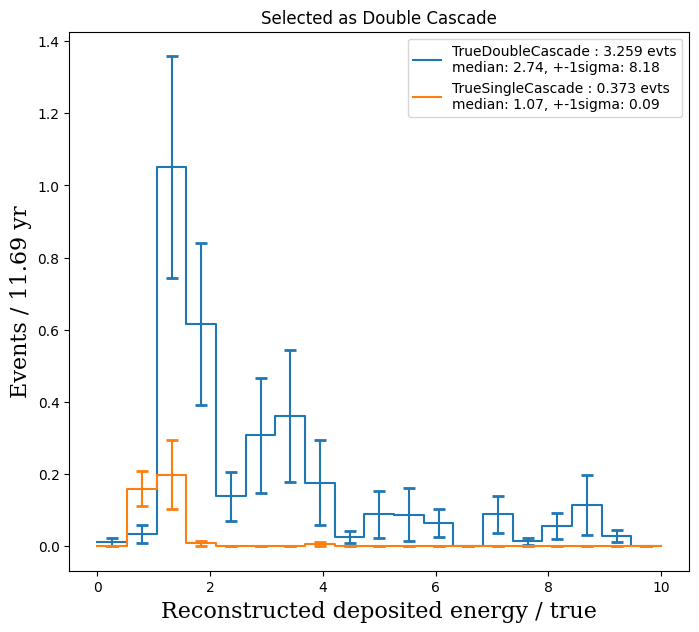

In [16]:
# energy resolution
bins = np.linspace(0,10,20)
livetime_yr = 11.687
livetime_s  = livetime_yr * 365.25 * 24 * 3600 # 11.687 year

for variable in ["RecoETot"]:

    plotting_path = f"{main_plotting_path}/{variable}_resolution"
    os.system(f"mkdir -p {plotting_path}")

    fig, ax = plt.subplots(1, 1,figsize =(8,7))

    for selection_name in ["DoubleCascade_TrueDoubleCascade", "DoubleCascade_TrueSingleCascade"]:
        
        selection = selections[selection_name]
        selection_name = selection_name.split("_")[1]

        y = np.abs(files['NuAll']['variables'][variable][ selection ]) / files['NuAll']['variables']['TrueETot'][ selection ]
        w = files['NuAll']['variables']['Weights_Astro'][selection]

        hist,hist_err = make_hist_error(samples=y, bins=bins,weights=w*368813893.34)

        quantiles = weighted_quantile( values=y, quantiles=[0.16,0.5,0.84], sample_weight=w)

        label = f"{selection_name} : {sum(hist):.3f} evts\nmedian: {quantiles[1]:.2f}, +-1sigma: {(quantiles[2]-quantiles[0])/2:.2f}"

        plot_hist_errorbar(ax=ax,hist=hist,bins=bins,yerror=hist_err,label=label)

    ax.legend()
    ax.set_ylabel(f"Events / {livetime_yr:.2f} yr",fontdict=font_axis_label)
    ax.set_xlabel("Reconstructed deposited energy / true",fontdict=font_axis_label)
    ax.set_title("Selected as Double Cascade")
    plt.savefig(f"{plotting_path}/{variable}_resolution_selection-NehaHESE.pdf")
